# Assignment 2

In [216]:
import os

import graphviz
import IPython.display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics  # use existing libraries!
import tqdm
import yaml
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture

In [217]:
# score function: binary cross entropy loss
def score_yp(y, p):  # y, p are numpy arrays
    return sklearn.metrics.log_loss(y, p)

In [218]:
# score wrapper, for data frames. we need this when using the `truth` data frame
def score(x, y):  # x, y are data frames
    xy = pd.merge(x, y, on=["customer", "product", "week"])
    assert xy.shape[0] == x.shape[0]
    return score_yp(xy["y"].values, xy["probability"].values)

## Input

In [219]:
# the path that contains the data
path = os.path.expandvars("/Users/vlad/Learning-from-Big-Data-Module-2/Assignment 2/")

# note that you don't have access to the truth data set
path_truth = os.path.expandvars(
    "/Users/vlad/Learning-from-Big-Data-Module-2/Assignment 2/"
)

In [220]:
# INPUT
training_week = 88  # for model training
validation_week = 89  # for model and baseline validation
test_week = 90  # for the final prediction (one week in the future, beyond our data)
target_customers = list(range(2000))
target_products = list(range(250))

## Load data

In [221]:
# baskets = pd.read_parquet(f"{path}/baskets-s.parquet")
# we only keep the 2000 customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2021)
# baskets = baskets[baskets["customer"]<2000]
# baskets.head()

In [261]:
baskets = pd.read_parquet(f"{path}/baskets-s.parquet")
# we only keep the the customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2021)
baskets = baskets[baskets["customer"].isin(target_customers)]
baskets

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592
...,...,...,...,...
68091869,89,1999,144,562
68091870,89,1999,158,566
68091871,89,1999,192,549
68091872,89,1999,213,592


# Data characteristics

In [223]:
baskets.describe()

,week,customer,product,price
count,1.378720e+06,1.378720e+06,1.378720e+06,1.378720e+06
mean,4.447746e+01,9.972110e+02,1.250727e+02,5.843381e+02
std,2.597662e+01,5.762501e+02,6.970123e+01,9.743281e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.340000e+02
25%,2.200000e+01,4.990000e+02,6.600000e+01,5.060000e+02
50%,4.400000e+01,9.930000e+02,1.230000e+02,5.790000e+02
75%,6.700000e+01,1.496000e+03,1.890000e+02,6.540000e+02
max,8.900000e+01,1.999000e+03,2.490000e+02,8.370000e+02


In [224]:
baskets

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592
...,...,...,...,...
68091869,89,1999,144,562
68091870,89,1999,158,566
68091871,89,1999,192,549
68091872,89,1999,213,592


In [225]:
# Average size of the basket.
# Another measure is the average number of items per shopping which can be calculated
# by grouping the items by customer number and date.

item_qty = (
    baskets[["customer", "week", "product"]]
    .groupby(["customer", "week"])
    .count()
    .reset_index()
)
item_qty

# Item_qty df -  number of items in each shopping. For instance, customer 0 purchased 10 items on week: 0
# customer 1999 purchased 7 products on week 90

,customer,week,product
0,0,0,10
1,0,1,7
2,0,2,9
3,0,3,8
4,0,4,8
...,...,...,...
179961,1999,85,7
179962,1999,86,8
179963,1999,87,9
179964,1999,88,8


In [226]:
# The average number of items per shopping is around 7,66
item_qty["product"].mean()

7.661002633830835

Text(0.5, 1.0, 'Histogram of Products per Shopping')

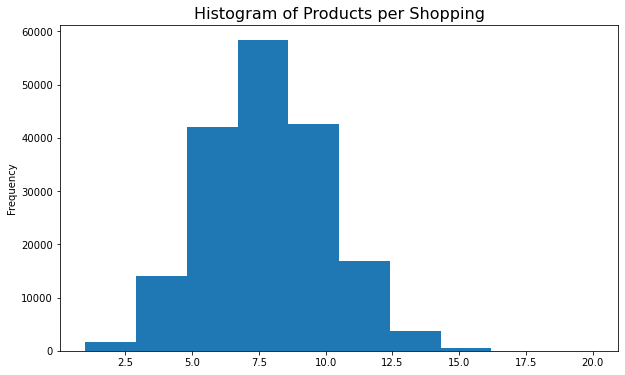

In [227]:
# Also check the distribution of the number of items per basket.

import matplotlib.pyplot as plt

item_qty["product"].plot(figsize=(10, 6), kind="hist", legend=False, fontsize=10)

plt.title("Histogram of Products per Shopping", fontsize=16)

Text(0, 0.5, 'Qty')

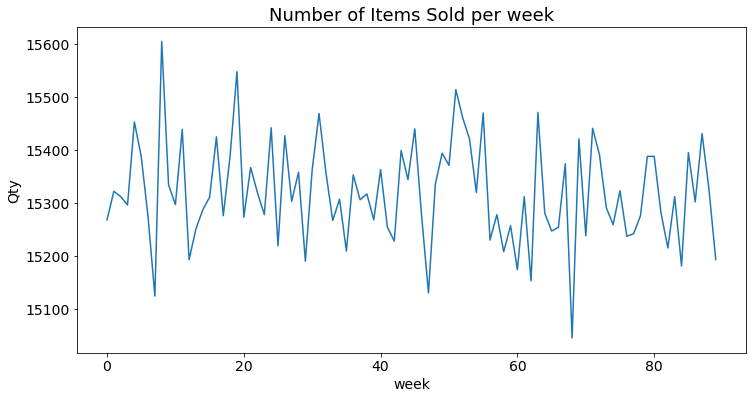

In [228]:
# Number of products sold per week

baskets[["week", "product"]].groupby("week").count().plot(
    figsize=(12, 6), legend=False, fontsize=14
)
plt.title("Number of Items Sold per week", fontsize=18)
plt.xlabel("week", fontsize=14)
plt.ylabel("Qty", fontsize=14)

# Category formation

In [229]:
baskets["basket"] = baskets["customer"] * 1000000 + baskets["week"]

In [230]:
# create a (binary) space matrix that indicates whether a basket (row) contains a product (col)
# co-occurrences are the dot produdct of this basket-product matrix
# return data frame
def get_co_occurrences(x, variable_basket="basket", variable_product="product"):
    row = x[variable_basket].values
    col = x[variable_product].values
    dim = (x[variable_basket].max() + 1, x[variable_product].max() + 1)

    basket_product_table = scipy.sparse.csr_matrix(
        (np.ones(len(row), dtype=int), (row, col)), shape=dim
    )
    co_occurrences_sparse = basket_product_table.T.dot(basket_product_table).tocoo()
    co_occurrences_df = pd.DataFrame(
        {
            "product_1": co_occurrences_sparse.row,
            "product_2": co_occurrences_sparse.col,
            "co-occurrence": co_occurrences_sparse.data,
        }
    )
    return co_occurrences_df

In [231]:
co_occurrences = get_co_occurrences(baskets)
co_occurrences

,product_1,product_2,co-occurrence
0,208,0,15
1,233,0,1
2,59,0,4
3,71,0,6
4,70,0,12
...,...,...,...
60177,184,249,296
60178,130,249,262
60179,76,249,2028
60180,67,249,595


In [232]:
print(co_occurrences.loc[0].at["product_2"])

print(co_occurrences.loc[0].at["product_1"])

print(co_occurrences.loc[0].at["co-occurrence"])

co_oc_mat = np.zeros((250, 250))

sec = co_occurrences.loc[0].at["product_2"]
co_oc_mat[sec][sec] = 5
co_oc_mat

0
208
15


array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [233]:
co_oc_mat = np.zeros((250, 250))

for index, prod_1 in co_occurrences["product_1"].items():
    prod_2 = co_occurrences.loc[index].at["product_2"]
    co_oc_mat[prod_1][prod_2] = co_occurrences.loc[index].at["co-occurrence"]

co_oc_mat

array([[2.9750e+03, 0.0000e+00, 0.0000e+00, ..., 9.0000e+00, 9.0000e+01,
        4.3200e+02],
       [0.0000e+00, 1.0153e+04, 0.0000e+00, ..., 4.0000e+01, 5.1500e+02,
        3.5100e+02],
       [0.0000e+00, 0.0000e+00, 2.8980e+03, ..., 4.9000e+01, 2.3400e+02,
        1.2200e+02],
       ...,
       [9.0000e+00, 4.0000e+01, 4.9000e+01, ..., 1.2670e+03, 0.0000e+00,
        0.0000e+00],
       [9.0000e+01, 5.1500e+02, 2.3400e+02, ..., 0.0000e+00, 1.1548e+04,
        0.0000e+00],
       [4.3200e+02, 3.5100e+02, 1.2200e+02, ..., 0.0000e+00, 0.0000e+00,
        1.1607e+04]])

In [234]:
np.fill_diagonal(co_oc_mat, 0)
# fill diagonal with "0" since it the information about the product occurs in the basket does not give us any relevant info.

dfmax, dfmin = co_oc_mat.max(), co_oc_mat.min()
co_oc_mat_norm = (co_oc_mat - dfmin) / (dfmax - dfmin)

In [235]:
prediction_index = pd.read_parquet(f"{path}/prediction_index.parquet")
prediction_index.head()

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4


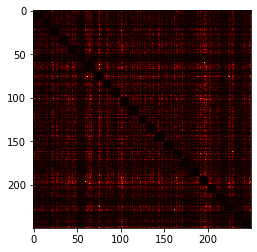

In [236]:
plt.imshow(co_oc_mat_norm, cmap="hot", interpolation="nearest")
plt.show()

## Derived category-product map

In [237]:
category_product_map = pd.DataFrame(
    {"product": list(range(250)), "category": np.repeat(range(25), 10),}
)
category_product_map

,product,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
245,245,24
246,246,24
247,247,24
248,248,24


In [238]:
## Building category features

### Step 1: Merge category ID to basket data

# Note: you can do the same with coupon data, e.g., when building a binary feature "is there a coupon for a customer-week-category combination (1) or not (0)".

In [239]:
# add category id to basket data
baskets = baskets.merge(category_product_map, on="product")
baskets

,week,customer,product,price,basket,category
0,0,0,71,629,0,7
1,0,47,71,629,47000000,7
2,0,55,71,629,55000000,7
3,0,96,71,629,96000000,7
4,0,110,71,629,110000000,7
...,...,...,...,...,...,...
1378715,89,1109,175,692,1109000089,17
1378716,89,1150,175,692,1150000089,17
1378717,89,1242,175,692,1242000089,17
1378718,89,1523,175,553,1523000089,17


In [240]:
# Example "Purchase frequencies" from lecture

# Customer A:
# Product A    0 0 1 0 0 ? 0 0 1 0  -> 2  -> 20% / recency: 2 weeks
# Product B    0 0 ? 0 0 1 0 0 ? 0  -> 1  -> 10% / recency: 5 weeks
# ------------
# Category 1   0 0 1 0 0 1 0 0 1 0  -> 3  -> 30% / recency: 2 weeks

# Customer B:
# Product A    0 0 1 0 0 1 0 0 1 0  -> 3  -> 30%
# Product B    0 0 0 0 0 0 0 0 0 0  -> 0  -> 0%
# ------------
# Category 1   0 0 1 0 0 1 0 0 1 0  -> 3  -> 30%

In [241]:
### Step 2: Build category-level feature(s)

In [242]:
# important: only use data before training week!!!
baskets_train = baskets[baskets["week"] < training_week]

In [243]:
baskets_train.head()

,week,customer,product,price,basket,category
0,0,0,71,629,0,7
1,0,47,71,629,47000000,7
2,0,55,71,629,55000000,7
3,0,96,71,629,96000000,7
4,0,110,71,629,110000000,7


In [244]:
n_weeks = baskets_train.week.nunique()

In [245]:
# customer-product feature
purchase_frequency_ij = (
    (
        baskets_train.groupby(["customer", "product"])[
            ["week"]
        ].count()  # number of weeks with purchase
        / n_weeks  # number of weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ij

,customer,product,probability
0,0,4,0.090909
1,0,11,0.102273
2,0,15,0.011364
3,0,16,0.034091
4,0,21,0.011364
...,...,...,...
141147,1999,237,0.045455
141148,1999,242,0.397727
141149,1999,243,0.011364
141150,1999,245,0.125000


In [246]:
# customer-category feature
purchase_frequency_ic = (
    (
        baskets_train.groupby(["customer", "category"])[
            ["week"]
        ].count()  # number of weeks with purchase
        / n_weeks  # number of weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ic

,customer,category,probability
0,0,0,0.090909
1,0,1,0.147727
2,0,2,0.011364
3,0,3,0.068182
4,0,4,0.034091
...,...,...,...
48256,1999,20,0.034091
48257,1999,21,0.215909
48258,1999,22,0.625000
48259,1999,23,0.045455


## Compare importance of products within categories based on the conditional probability to choose a product given the category

In [253]:
purchase_frequency_i = purchase_frequency_ij.merge(
    category_product_map, on="product"
).merge(
    purchase_frequency_ic,
    on=["customer", "category"],
    suffixes=["_product", "_category"],
)

purchase_frequency_i

,customer,product,probability_product,category,probability_category
0,0,4,0.090909,0,0.090909
1,1,4,0.102273,0,0.318182
2,1,0,0.068182,0,0.318182
3,1,1,0.147727,0,0.318182
4,3,4,0.034091,0,0.409091
...,...,...,...,...,...
141147,1822,174,0.159091,17,0.159091
141148,1831,174,0.011364,17,0.011364
141149,1861,174,0.409091,17,0.409091
141150,1896,174,0.022727,17,0.022727


In [254]:
# added conditional probability of choosing a product given we choose its category

purchase_frequency_i["conditional_probability_product|category"] = (
    purchase_frequency_i["probability_product"]
    * purchase_frequency_i["probability_category"]
)

purchase_frequency_i

,customer,product,probability_product,category,probability_category,conditional_probability_product|category
0,0,4,0.090909,0,0.090909,0.008264
1,1,4,0.102273,0,0.318182,0.032541
2,1,0,0.068182,0,0.318182,0.021694
3,1,1,0.147727,0,0.318182,0.047004
4,3,4,0.034091,0,0.409091,0.013946
...,...,...,...,...,...,...
141147,1822,174,0.159091,17,0.159091,0.025310
141148,1831,174,0.011364,17,0.011364,0.000129
141149,1861,174,0.409091,17,0.409091,0.167355
141150,1896,174,0.022727,17,0.022727,0.000517


## Average out the conditional probabilities of choosing a product given the category over the 2000 customers in the S dataset -> find category leaders

In [259]:
mean_purchase_frequency = pd.DataFrame(
    {
        "category": np.repeat(range(25), 10),
        "product": list(range(250)),
        "mean_cond_prob": np.zeros(250),
    }
)

for categ in range(25):
    for prod in range(250):
        mean_purchase_frequency.loc[
            (mean_purchase_frequency["product"] == prod)
            & (mean_purchase_frequency["category"] == categ),
            "mean_cond_prob",
        ] = purchase_frequency_i[
            (purchase_frequency_i["product"] == prod)
            & (purchase_frequency_i["category"] == categ)
        ][
            "conditional_probability_product|category"
        ].mean()

mean_purchase_frequency

,category,product,mean_cond_prob
0,0,0,0.040790
1,0,1,0.062898
2,0,2,0.031712
3,0,3,0.010318
4,0,4,0.031308
...,...,...,...
245,24,245,0.022450
246,24,246,0.047704
247,24,247,0.023400
248,24,248,0.060011


In [334]:
# the category-leading products in each category are defined as showing a mean conditional probability of being bought larger than 10% -> some categories don't have such products, some have multiple such products

category_leaders = mean_purchase_frequency[
    (mean_purchase_frequency["mean_cond_prob"] > 0.1)
]
category_leaders

,category,product,mean_cond_prob
22,2,22,0.105401
40,4,40,0.125699
60,6,60,0.148584
67,6,67,0.110737
76,7,76,0.164883
98,9,98,0.111077
101,10,101,0.125821
105,10,105,0.152243
138,13,138,0.100531
192,19,192,0.116105


# Optional section (work in progress)

In [263]:
purchase_frequency_i.loc[purchase_frequency_i["probability_product"].idxmax()]

customer                                    1991.0
product                                       75.0
probability_product                            1.0
category                                       7.0
probability_category                           1.0
conditional_probability_product|category       1.0
Name: 100969, dtype: float64

In [264]:
### Step 3: Merge features to base table

In [265]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):

    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [266]:
base_table = build_target(baskets, training_week).merge(
    category_product_map, on="product"
)
base_table

,week,customer,product,y,category
0,88,0,0,0,0
1,88,1,0,0,0
2,88,2,0,0,0
3,88,3,0,0,0
4,88,4,0,0,0
...,...,...,...,...,...
499995,88,1995,249,0,24
499996,88,1996,249,1,24
499997,88,1997,249,0,24
499998,88,1998,249,0,24


In [267]:
base_table = base_table.merge(
    purchase_frequency_ic, on=["customer", "category"], how="left"
).fillna(
    0
)  # note that we need to add missing values!

# Using the features created to model purchase probability

<br> 

## Reminder

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/time-split.png" width="900"/>

## Some first steps

In [269]:
baskets.week.max()

89

In [270]:
n_weeks = baskets.week.nunique()
print(n_weeks)

90


In [271]:
(baskets[(baskets["customer"] == 0) & (baskets["product"] == 4)].week.count() / n_weeks)

0.08888888888888889

In [272]:
# this is our first "model" – wow, that's easy
purchase_frequency_ij = (
    (baskets.groupby(["customer", "product"])[["week"]].count() / n_weeks)
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ij

,customer,product,probability
0,0,4,0.088889
1,0,11,0.100000
2,0,15,0.011111
3,0,16,0.044444
4,0,21,0.011111
...,...,...,...
142059,1999,237,0.044444
142060,1999,242,0.388889
142061,1999,243,0.011111
142062,1999,245,0.133333


In [273]:
test_week

90

In [274]:
# add all missing values
# Q1: what values are missing?
# Q2: what is a good value for probabilities here?
df = pd.DataFrame(
    {
        "week": test_week,
        "customer": np.repeat(target_customers, len(target_products), axis=0),
        "product": target_products * len(target_customers),
    }
)
df

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4
...,...,...,...
499995,90,1999,245
499996,90,1999,246
499997,90,1999,247
499998,90,1999,248


In [275]:
result_baseline = pd.merge(
    df, purchase_frequency_ij, on=["customer", "product"], how="left",
).fillna(0)
result_baseline

,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889
...,...,...,...,...
499995,90,1999,245,0.133333
499996,90,1999,246,0.000000
499997,90,1999,247,0.000000
499998,90,1999,248,0.000000


<br>

## SOLUTION 1: Descriptive feature (past purchase rates) = Baseline

Now we have predictions, but we have no idea how good this baseline is.  So let's do the following:
1. construct a ground truth data set
1. do a proper train/validation split
1. predict purchase probabilities using our baseline
1. evaluate the predictions vs. the base

### Validation

In [276]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):

    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [277]:
validation_week

89

In [278]:
baseline_target = build_target(baskets, validation_week)
baseline_target.head()

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0


In [279]:
baseline_target.describe()

,week,customer,product,y
count,500000.0,500000.000000,500000.000000,500000.000000
mean,89.0,999.500000,124.500000,0.030386
std,0.0,577.350774,72.168278,0.171647
min,89.0,0.000000,0.000000,0.000000
25%,89.0,499.750000,62.000000,0.000000
50%,89.0,999.500000,124.500000,0.000000
75%,89.0,1499.250000,187.000000,0.000000
max,89.0,1999.000000,249.000000,1.000000


In [280]:
# the perfect prediction has a loss of 0
score_yp(baseline_target.y.values, baseline_target.y.values)

9.99200722162641e-16

In [281]:
# wrap code into function:
# baseline = purchase rates for customer-product combinations before the target week
def baseline_prediction(baskets, week):

    # subset baskets
    baskets_t = baskets[baskets["week"] < week].reset_index(drop=True)
    n_weeks = baskets_t.week.nunique()
    print(n_weeks)

    # model (non-0 probabilities)
    purchase_frequency_ij = (
        (baskets_t.groupby(["customer", "product"])[["week"]].count() / n_weeks)
        .rename(columns={"week": "probability"})
        .reset_index()
    )

    # filling in 0s
    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    result_baseline = pd.merge(
        df, purchase_frequency_ij, on=["customer", "product"], how="left",
    ).fillna(0)

    return result_baseline

In [282]:
# prediction for validation data
baseline_validation = baseline_prediction(baskets, validation_week)
baseline_validation.head()

89


,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888


In [283]:
baseline_target

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0
...,...,...,...,...
499995,89,1999,245,1
499996,89,1999,246,0
499997,89,1999,247,0
499998,89,1999,248,0


In [284]:
baseline_validation

,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888
...,...,...,...,...
499995,89,1999,245,0.123596
499996,89,1999,246,0.000000
499997,89,1999,247,0.000000
499998,89,1999,248,0.000000


In [285]:
# score for validation data
score(baseline_target, baseline_validation)

0.10034939532139737

### Test

In [286]:
validation_week + 1

90

In [287]:
test_week

90

In [288]:
# prediction for test data
# we can't evaluate this
baseline_test = baseline_prediction(baskets, test_week)
baseline_test.head()

90


,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889


Conclusion:
1. Train model to week 88, evaluate predictions for week 89 with truth data 
1. Predcit week 90, and submit

<br>

## SOLUTION 2: simple machine learning model   

### Example for constructing the features

In [289]:
def build_frequency_feature(baskets, week_start, week_end, feature_name):
    # subset baskets
    baskets_subset = baskets[
        (baskets["week"] >= week_start) & (baskets["week"] <= week_end)
    ]
    print(baskets_subset.week.nunique())

    purchase_frequency_ij = (
        (
            baskets_subset.groupby(["customer", "product"])[["week"]].count()
            / baskets_subset.week.nunique()
        )
        .rename(columns={"week": feature_name})
        .reset_index()
    )

    return purchase_frequency_ij

In [290]:
build_frequency_feature(baskets, -1, training_week - 1, "frequency_full")

88


,customer,product,frequency_full
0,0,4,0.090909
1,0,11,0.102273
2,0,15,0.011364
3,0,16,0.034091
4,0,21,0.011364
...,...,...,...
141147,1999,237,0.045455
141148,1999,242,0.397727
141149,1999,243,0.011364
141150,1999,245,0.125000


### Example for building the base table

In [291]:
def build_base_table(baskets, week):
    # target variable (product purchase)
    # consider using multiple weeks for training! more data might lead to better results.
    # also, different weeks might have different information.
    y = build_target(baskets, week)
    # features
    # note how features are computed on data BEFORE the target week
    x_1 = build_frequency_feature(baskets, -1, week - 1, "frequency_full")
    x_2 = build_frequency_feature(baskets, week - 30, week - 1, "frequency_l30")
    x_3 = build_frequency_feature(baskets, week - 5, week - 1, "frequency_l5")
    base_table_yx = (
        y.merge(x_1, on=["customer", "product"], how="left")
        .merge(x_2, on=["customer", "product"], how="left")
        .merge(x_3, on=["customer", "product"], how="left")
        .fillna(0)
    )
    return base_table_yx

In [292]:
build_base_table(baskets, training_week)

88
30
5


,week,customer,product,y,frequency_full,frequency_l30,frequency_l5
0,88,0,0,0,0.000000,0.000000,0.0
1,88,0,1,0,0.000000,0.000000,0.0
2,88,0,2,0,0.000000,0.000000,0.0
3,88,0,3,0,0.000000,0.000000,0.0
4,88,0,4,0,0.090909,0.100000,0.0
...,...,...,...,...,...,...,...
499995,88,1999,245,0,0.125000,0.133333,0.0
499996,88,1999,246,0,0.000000,0.000000,0.0
499997,88,1999,247,0,0.000000,0.000000,0.0
499998,88,1999,248,0,0.000000,0.000000,0.0


## Training the 3 models (week < 89)

In [295]:
base_table_train = build_base_table(baskets, training_week)

88
30
5


In [296]:
y = base_table_train["y"].values  # 1s and 0s

In [297]:
X = base_table_train[
    ["frequency_full", "frequency_l30", "frequency_l5"]
].values  # purchase frequencies

### Logistic Regression

In [300]:
log_reg = sklearn.linear_model.LogisticRegression().fit(X, y)

In [301]:
log_reg.intercept_, log_reg.coef_

(array([-4.48545291]), array([[10.74680489,  0.30805447, -0.98091252]]))

In [302]:
base_table_train["probability"] = log_reg.predict_proba(X)[:, 1]

In [303]:
score_yp(
    base_table_train["y"].values, base_table_train["probability"].values,
)

0.09008063416504795

In [304]:
print(
    mean_absolute_error(
        base_table_train["y"].values, base_table_train["probability"].values
    )
)
print(
    mean_squared_error(
        base_table_train["y"].values, base_table_train["probability"].values
    )
)
print(r2_score(base_table_train["y"].values, base_table_train["probability"].values))

0.04315700488184254
0.022914788074339738
0.2288304561136496


### Random Forest

In [306]:
rf = sklearn.ensemble.RandomForestClassifier().fit(X, y)

In [307]:
base_table_train["probability"] = rf.predict_proba(X)[:, 1]

In [308]:
score_yp(
    base_table_train["y"].values, base_table_train["probability"].values,
)

0.07490022185000547

In [309]:
print(
    mean_absolute_error(
        base_table_train["y"].values, base_table_train["probability"].values
    )
)
print(
    mean_squared_error(
        base_table_train["y"].values, base_table_train["probability"].values
    )
)
print(r2_score(base_table_train["y"].values, base_table_train["probability"].values))

0.04124487150674385
0.020550062150691568
0.308412453819231


### Boosted Trees

In [310]:
boost_tr = sklearn.ensemble.GradientBoostingClassifier().fit(X, y)
X

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.09090909, 0.        , 0.        ]])

In [311]:
base_table_train["probability"] = boost_tr.predict_proba(X)[:, 1]

In [312]:
score_yp(
    base_table_train["y"].values, base_table_train["probability"].values,
)

0.07752181997123096

In [313]:
print(
    mean_absolute_error(
        base_table_train["y"].values, base_table_train["probability"].values
    )
)
print(
    mean_squared_error(
        base_table_train["y"].values, base_table_train["probability"].values
    )
)
print(r2_score(base_table_train["y"].values, base_table_train["probability"].values))

0.04307403389317016
0.021498388072914095
0.27649768914746464


## Validation: Test model performance for the 3 models (week 89)

In [314]:
base_table_validation = build_base_table(baskets, validation_week)

89
30
5


In [315]:
X_validation = base_table_validation[
    ["frequency_full", "frequency_l30", "frequency_l5"]
].values

### Logistic Regression

In [316]:
base_table_validation["probability"] = log_reg.predict_proba(X_validation)[:, 1]

In [317]:
score_yp(
    base_table_validation["y"].values, base_table_validation["probability"].values,
)

0.08962234697918602

In [318]:
print(
    mean_absolute_error(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)
print(
    mean_squared_error(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)
print(
    r2_score(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)

0.043041289767999015
0.022802397878428783
0.22605854722051644


### Random Forest

In [320]:
base_table_validation["probability"] = rf.predict_proba(X_validation)[:, 1]

In [321]:
score_yp(
    base_table_validation["y"].values, base_table_validation["probability"].values,
)

0.08817880889534047

In [322]:
print(
    mean_absolute_error(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)
print(
    mean_squared_error(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)
print(
    r2_score(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)

0.04296803597785432
0.02224275617913681
0.2450534753897048


### Boosted Trees

In [324]:
base_table_validation["probability"] = boost_tr.predict_proba(X_validation)[:, 1]

In [325]:
score_yp(
    base_table_validation["y"].values, base_table_validation["probability"].values,
)

0.07712281180815277

In [326]:
print(
    mean_absolute_error(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)
print(
    mean_squared_error(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)
print(
    r2_score(
        base_table_validation["y"].values, base_table_validation["probability"].values
    )
)

0.04319986823232003
0.02146063368809061
0.2715996754954594


## Test: Produce final result for the 3 models (week 90)

In [327]:
base_table_test = build_base_table(baskets, test_week)

90
30
5


In [328]:
X_test = base_table_test[["frequency_full", "frequency_l30", "frequency_l5"]].values

### Logistic regression predictions

In [329]:
base_table_test["probability"] = log_reg.predict_proba(X_test)[:, 1]
base_table_test["probability"]

0         0.011146
1         0.011146
2         0.011146
3         0.011146
4         0.029039
            ...   
499995    0.039264
499996    0.011146
499997    0.011146
499998    0.011146
499999    0.028466
Name: probability, Length: 500000, dtype: float64

### Random forest predictions

In [331]:
base_table_test["probability"] = rf.predict_proba(X_test)[:, 1]
base_table_test["probability"]

0         0.001330
1         0.001330
2         0.001330
3         0.001330
4         0.099754
            ...   
499995    0.151810
499996    0.001330
499997    0.001330
499998    0.001330
499999    0.137905
Name: probability, Length: 500000, dtype: float64

### Boosted trees predictions

In [333]:
base_table_test["probability"] = boost_tr.predict_proba(X_test)[:, 1]
base_table_test["probability"]

0         0.001487
1         0.001487
2         0.001487
3         0.001487
4         0.096932
            ...   
499995    0.121709
499996    0.001487
499997    0.001487
499998    0.001487
499999    0.096932
Name: probability, Length: 500000, dtype: float64

# Thank you for the attention!